In [1]:
import numpy as np
import torch
import xarray as xr
import pandas as pd 
import tqdm

from dantro.plot.utils import ColorManager

import include as base
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams
from cycler import cycler
colors = {
    
    'c_darkblue': '#2F7194',
    'c_red': '#ec7070',
    'c_darkgreen': '#48675A',
    'c_lightblue': '#97c3d0',
    'c_lightgreen': '#AFD8BC',
    'c_lightbrown': '#C6BFA2',
    'c_orange': '#EC9F7E',
    'c_yellow': '#F5DDA9',
    'c_darkgrey': '#3D4244',
    'c_pink': '#F8A6A6',
    'c_purple': '#A07CB0',
    'c_lightgrey': '#AFC1B9',
}
rcParams['axes.prop_cycle'] = cycler(color=list(colors.values()))
fs=9
rcParams.update(**{
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amssymb} \usepackage{amsmath}",
    "font.size": fs, 
    "axes.titlesize": fs,
    "axes.labelsize": fs,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "grid.linewidth": 0.5,
    "savefig.bbox": "tight",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False
})

In [75]:
# Lookup tables
iso3_to_name = pd.read_csv("/Users/thomasgaskin/UN_migration_data/Iso_code_lookup.csv").set_index('Alpha-3 code')['Country'].to_dict()
iso2_to_3 = (pd.read_csv("/Users/thomasgaskin/UN_migration_data/Iso_code_lookup.csv")[["Alpha-2 code", "Alpha-3 code"]]).set_index("Alpha-2 code").to_dict()['Alpha-3 code']

In [4]:
device = "cpu"
torch.set_default_device(device)

In [101]:
# Get the migration data
UN_data = pd.read_csv("/Users/thomasgaskin/UN_migration_data/UN_data.csv", low_memory=False, index_col=0).drop(["Notes", "Location code", "SDMX code**", "Parent code", "ISO2 Alpha-code"], axis=1).set_index(["Variant", "Year", "ISO3 Alpha-code"])
UN_data = UN_data[UN_data.Type == "Country/Area"].to_xarray().squeeze(drop=True)
UN_data = UN_data.assign_coords({"Year": UN_data.coords["Year"].data.astype(int)}).rename({'ISO3 Alpha-code': 'country', 'Year': 'year'})
# Drop the Holy See (all NAN)
UN_data = UN_data.drop_sel({"country": "VAT"})

# Convert the strings to floats
for var in UN_data.data_vars:
    try:
        UN_data[var].data = np.reshape([float(s.replace(' ', '')) for s in UN_data[var].data.flatten()], UN_data[var].shape)
    except:
        continue

In [102]:
# Get the facebook data
fb_data = pd.read_csv("/Users/thomasgaskin/UN_migration_data/international_migration_flow-BETA VERSION 20230730-Data for Good at Meta.csv", low_memory=False)
fb_data["migration_month"] = pd.to_datetime(fb_data["migration_month"])
fb_data["year"] = [x.year for x in fb_data["migration_month"]]
fb_data["month"] = [x.month for x in fb_data["migration_month"]]
fb_data.drop("migration_month", axis=1, inplace=True)
fb_data = fb_data.set_index(["country_from", "country_to", "year", "month"])
fb_data = fb_data.to_xarray().sum('month') / 1000
fb_data = fb_data.assign_coords({"country_from": [iso2_to_3[x] for x in fb_data.coords["country_from"].data]})
fb_data = fb_data.assign_coords({"country_to": [iso2_to_3[x] for x in fb_data.coords["country_to"].data]})
fb_data = fb_data.rename({"country_from": "source", "country_to": "destination"})
fb_data = fb_data['num_migrants']
fb_data = fb_data.where(fb_data > 0, np.nan)

In [111]:
# Get the immigration data for NZ and SWE and convert to a table
# Divide data by 1000 in order to get immigration in units of 1000
NZ_data = pd.read_csv("/Users/thomasgaskin/UN_migration_data/bilat_nzl.csv").drop("country", axis=1)
NZ_data = NZ_data[[isinstance(s, str) for s in NZ_data.iso3c]]
NZ_data["year"] = NZ_data["year"].astype(int)
NZ_data = NZ_data.set_index(["year", "iso3c", "direction"])
NZ_data = NZ_data[~NZ_data.index.duplicated()].to_xarray()
NZ_data = xr.Dataset({"arrivals": NZ_data["flow"].sel({"direction": "arrivals"}, drop=True),
            "departures": NZ_data["flow"].sel({"direction": "departures"}, drop=True)}) / 1000
SWE_data = pd.read_csv("/Users/thomasgaskin/UN_migration_data/bilat_swe.csv").set_index(["year", "iso3c", "age", "sex"]).drop("country", axis=1)
SWE_data = SWE_data[~SWE_data.index.duplicated()].to_xarray().sel({"age": "total", "sex": "total"}, drop=True).rename({"imm": "arrivals", "emi": "departures"}) / 1000

known_data = xr.concat([NZ_data, SWE_data], fill_value=np.nan, dim=pd.Index(["NZL", "SWE"], name="reporter")).rename({'iso3c': 'country'})

common_countries = [c for c in known_data.coords['country'].data if c in UN_data.coords['country'].data]
known_data = known_data.sel({'country': common_countries})
known_data_table = np.nan * xr.DataArray(
    np.zeros((len(UN_data.coords['year']), len(UN_data.coords['country']), len(UN_data.coords['country']))), 
    dims=['year', 'source', 'destination'], 
    coords={'year': UN_data.coords['year'].data, 'source': UN_data.coords['country'].data, 'destination': UN_data.coords['country'].data}
)

# Add the facebook data
for year in fb_data.coords['year'].data:
    for source in fb_data.coords['source'].data:
        if source not in known_data_table.coords['source'].data:
            continue
        for destination in fb_data.coords['destination'].data:
            if destination not in known_data_table.coords['destination'].data:
                continue
            elif source == destination:
                known_data_table.loc[{'year': year, 'source': source, 'destination': destination}] = 0
                continue
            known_data_table.loc[{'year': year, 'source': source, 'destination': destination}] = fb_data.sel({'year': year, 'source': source, 'destination': destination}).data

# Combine into a single table
for year in known_data.coords['year']:
    for reporter in known_data.coords['reporter']:
        if all(np.isnan(known_data.sel({'year': year, 'reporter': reporter})['arrivals'].data)) and all(np.isnan(known_data.sel({'year': year, 'reporter': reporter})['departures'].data)):
            continue 
        else:
            for c in common_countries:
                if c == reporter:
                    known_data_table.loc[{'year': year, 'source': c, 'destination': reporter}] = 0
                    continue
                known_data_table.loc[{'year': year, 'source': c, 'destination': reporter}] = known_data.sel({'year': year, 'reporter': reporter, 'country': c})['arrivals']
                known_data_table.loc[{'year': year, 'source': reporter, 'destination': c}] = known_data.sel({'year': year, 'reporter': reporter, 'country': c})['departures']

In [366]:
YEAR_SEL = list(range(2010, 2022))

In [370]:
# Convert net migration to torch tensor
training_data = torch.from_numpy(
    UN_data['Net Number of Migrants (thousands)'].transpose('year', ...).sel({'year': YEAR_SEL}).data
).float().to(device)
N = training_data.shape[1]

population_data = torch.from_numpy(
        UN_data['Total Population, as of 1 January (thousands)'].transpose('year', ...).sel({'year': YEAR_SEL}).data
).float().to(device)

# Get the masks for year of known data (applied to the prediction) 
known_data_torch = torch.from_numpy(known_data_table.sel({'year': YEAR_SEL}).data).float().to(device)
masks = [~torch.isnan(x).to(device) for x in known_data_torch]
print(training_data.shape, known_data_torch.shape)

torch.Size([12, 236]) torch.Size([12, 236, 236])


In [371]:
# Initialise the Neural Network
NN = base.NeuralNet(
    input_size=N,
    output_size=N**2,
    num_layers=5,
    nodes_per_layer=dict(default=20),
    activation_funcs=dict(default='relu', layer_specific={-1: 'abs'}),
    biases=dict(default=None), 
    optimizer='Adam',
    learning_rate=0.002,
)
loss_ts = []#{'data': [], 'flow': [], 'trace': [], 'known_data': [], 'epoch_averaged': [], 'inflow': [], 'outflow': []}

In [400]:
# Train
import datetime
# Set random seed from current date and time
np.random.seed(int(datetime.datetime.now().strftime('%m%d%H%M%S')))
torch.random.manual_seed(int(datetime.datetime.now().strftime('%m%d%H%M%S')))
num_epochs = 15000
batch_size = 6

# Train
for it in (pbar:=tqdm.tqdm(range(num_epochs))):
    
    epoch_loss = []

    loss = torch.tensor(0.0, requires_grad=True)
    
    for j, dset in enumerate(training_data):

        # Make a prediction
        #predicted_ratios = torch.exp(-)
        prediction =  NN(dset).reshape(N, N) #* population_data[j]
        
        # Calculate the predicted net migration
        predicted_net_migration = torch.sum(prediction - torch.transpose(prediction, 0, 1), dim=0)
        
        # Match the net migration values
        data_loss =  torch.nn.functional.mse_loss(predicted_net_migration, dset, reduction='sum') #/ abs(dset).sum()**2

        # Set the trace to 0
        trace_loss = torch.trace(prediction)

        # Flows should sum to zero
        flow_loss = torch.abs(predicted_net_migration.sum())
        
        batch_loss = data_loss + flow_loss + trace_loss


        # Match known data, if given
        if len(known_data) > 0:
            batch_loss = batch_loss + torch.nn.functional.mse_loss(prediction[masks[j]], known_data_torch[j][masks[j]], reduction='sum')  
        
        loss = loss + batch_loss
        
        if j % batch_size == 0 or j == training_data.shape[0] - 1:
            loss.backward()
            NN.optimizer.step()
            NN.optimizer.zero_grad()
            loss = torch.tensor(0.0, requires_grad=True)
        
        epoch_loss.append(loss.detach().item())
    
    loss_ts.append(np.mean(epoch_loss).item())
    if loss_ts[-1] < 400:
        break
    pbar.set_description_str(f"Current loss: {'{:g}'.format(loss_ts[-1])}")

Current loss: 410.891:   4%|▍         | 670/15000 [00:18<06:35, 36.26it/s]


In [245]:
print(f"Data: {'{:g}'.format(data_loss.detach().item())}, Trace: {'{:g}'.format(trace_loss.detach().item())}, "
      f"Flow: {'{:g}'.format(flow_loss.detach().item())}, Known data: {'{:g}'.format(known_data_loss.detach().item())}")

Data: 1.27436e+06, Trace: 5.70615, Flow: 0.000244141, Known data: 855682


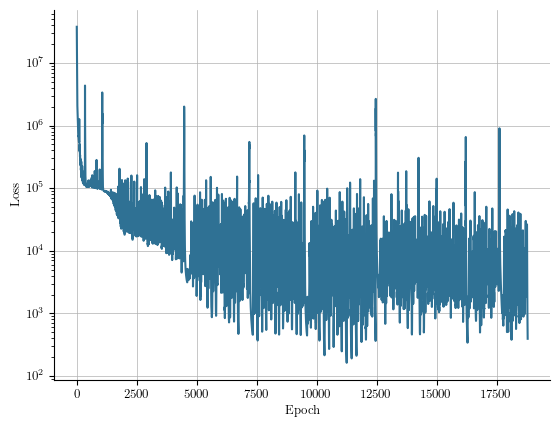

In [401]:
# Plot the training loss
fig, ax = plt.subplots()
ax.plot(np.arange(len(loss_ts)), loss_ts)
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.set_yscale('log')
# ax.set_ylim(0, 1.1)

In [402]:
# Get predictions for each year
predicted_transport_plans = xr.DataArray(
    torch.stack([
    NN(training_data[i]).reshape(N, N).detach() for i in range(len(training_data))
]), dims=["year", "source", "destination"],
    coords={"year": UN_data.sel({'year': YEAR_SEL}).coords["year"].data,
            "source": UN_data.coords["country"].data, 
            "destination": UN_data.coords["country"].data}
)

# Get the predicted net migration for each year
predicted_net_migration = (predicted_transport_plans.sum("source").rename({"destination": "source"}) - predicted_transport_plans.sum("destination")).rename({"source": "country"})

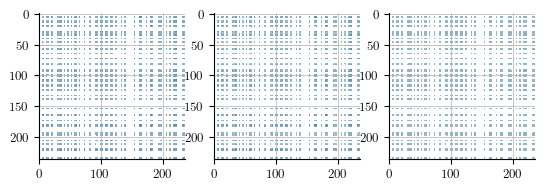

In [407]:
# Plot an example prediction on the training data
i = -3
example_dset = training_data[i]
T_pred = NN(example_dset).reshape(N, N).detach()

cm = ColorManager(
    cmap={'from_values': {0: 'white', 1: colors['c_darkblue']}, 'continuous': True}, norm='LogNorm'
)
fig, axs = plt.subplots(ncols=3)
axs[0].imshow(T_pred.where(~torch.isnan(known_data_torch[i]), torch.nan), cmap=cm.cmap, norm=cm.norm)
axs[1].imshow(known_data_torch[i], cmap=cm.cmap, norm=cm.norm)
axs[2].imshow(abs(known_data_torch[i] - T_pred.where(~torch.isnan(known_data_torch[i]), torch.nan)),cmap=cm.cmap, norm=cm.norm)

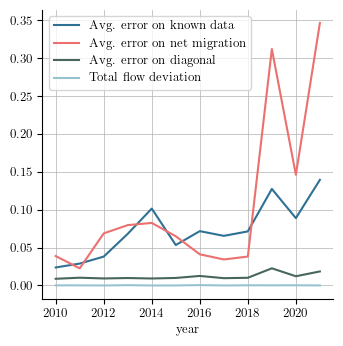

In [483]:
# Average error on known data
fig, ax = plt.subplots(figsize=(3.75, 3.75))
(abs(known_data_torch - predicted_transport_plans).mean(dim=['source', 'destination'], skipna=True)).plot.line(ax=ax, label="Avg. error on known data")
# ax.plot(predicted_transport_plans.coords['year'].data, torch.where(~torch.isnan(known_data_torch), 1, 0).sum(axis=[-2, -1]))
(abs((training_data-predicted_net_migration)).mean('country')).plot.line(ax=ax, label="Avg. error on net migration")
ax.plot(predicted_transport_plans.coords['year'].data, np.stack([abs(np.diag(x)).mean() for x in predicted_transport_plans.data]), label="Avg. error on diagonal")
ax.plot(predicted_transport_plans.coords['year'].data, abs(np.array(predicted_transport_plans.data - predicted_transport_plans.transpose('year', 'destination', 'source')).sum(axis=-1).sum(axis=-1)), label="Total flow deviation")
ax.legend()

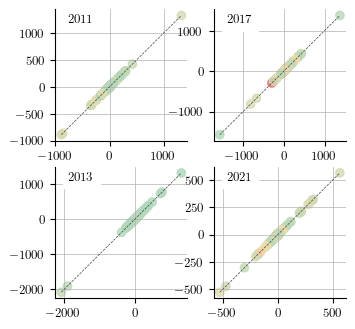

In [484]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(3.75, 3.75))

indices = range(4) if len(YEAR_SEL) <= 4 else np.random.choice(len(training_data), 4, replace=False)

for i, idx in enumerate(indices):
    color_data = abs((training_data[idx]-predicted_net_migration[idx]))
    cm = ColorManager(
    cmap={'from_values': {0: colors['c_lightgreen'], 0.5: colors['c_yellow'], 1: colors['c_red']}, 'continuous': True},
    vmin=color_data.min(), vmax=color_data.max())   
    axs.flatten()[i].scatter(training_data[idx], predicted_net_migration[idx], c=color_data, cmap=cm.cmap, alpha=0.8)
    _min = np.minimum(training_data[idx].numpy().min(), predicted_net_migration[idx].min().item())
    _max = np.maximum(training_data[idx].numpy().max(), predicted_net_migration[idx].max().item())
    axs.flatten()[i].plot(
        [_min, _max], [_min, _max], lw=0.5, color=colors['c_darkgrey'], linestyle='dashed'
    )
    axs.flatten()[i].text(0.1, 0.9, f"{UN_data.sel({'year': YEAR_SEL}).coords['year'].data[idx]}", transform=axs.flatten()[i].transAxes, backgroundcolor='white')
fig.savefig("/Users/thomasgaskin/Prediction_errors_2.png", dpi=400)

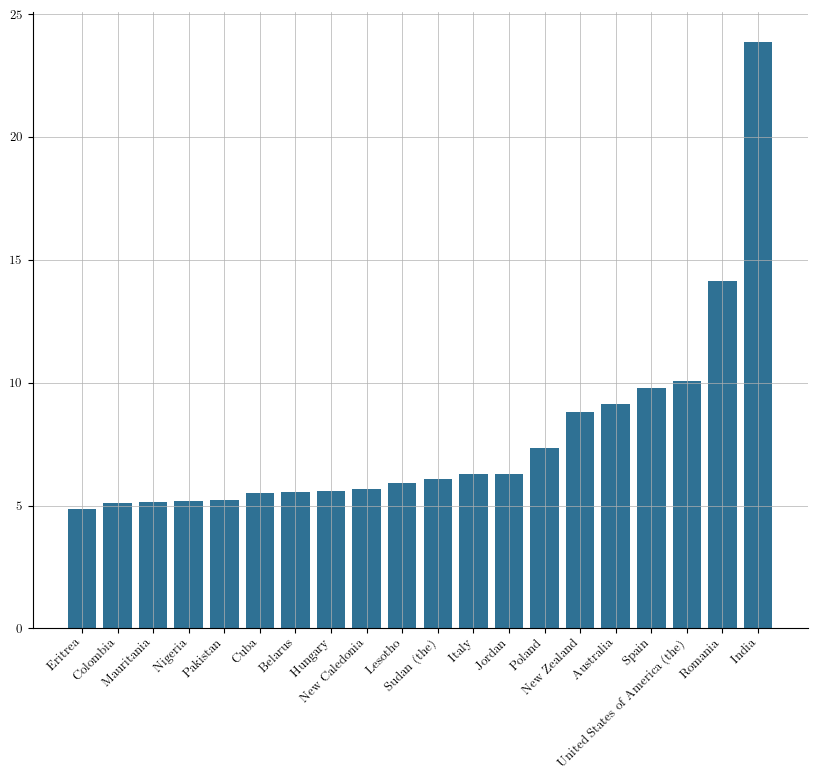

In [378]:
fig, ax = plt.subplots(figsize=(10, 8))
x, y = "destination", "source"
_ex = predicted_transport_plans.sel({"year": 2010, x: "GBR"}, drop=True)
_ex = _ex.isel({y: _ex.argsort().data[-20:]})
ax.bar(_ex.coords[y], _ex)
_ = ax.set_xticks(_ex.coords[y].data, [iso3_to_name.get(c, c) for c in _ex.coords[y].data], rotation=45, ha='right')

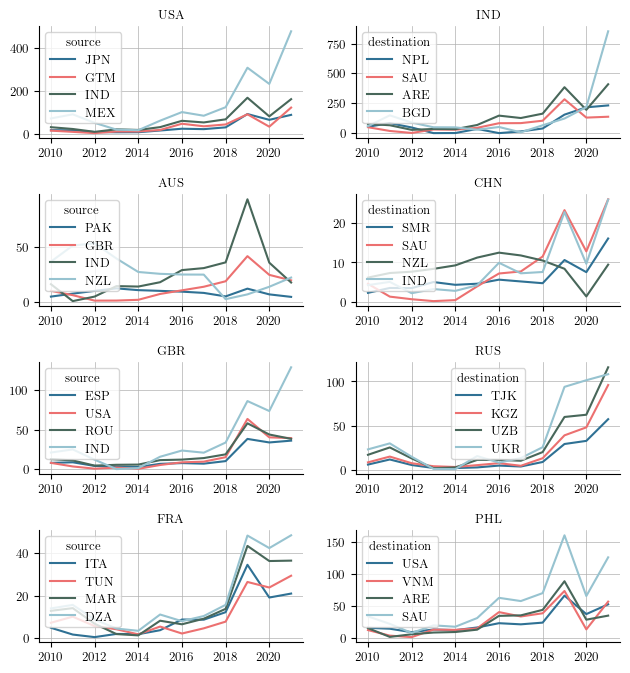

In [532]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(7.5, 8))
fig.subplots_adjust(hspace=0.5)
for idx, country in enumerate(["USA", "AUS", "GBR", "FRA"]):
    ex_data = predicted_transport_plans.sel({"destination": country}, drop=True)
    ex_data = ex_data.isel({"source": ex_data.mean('year').argsort().data[-4:]})
    _ = ex_data.plot.line(hue="source", ax=axs[idx, 0])
    axs[idx, 0].set_title(country)
    axs[idx, 0].set_xlabel('')

for idx, country in enumerate(["IND", "CHN", "RUS", "PHL"]):
    ex_data = predicted_transport_plans.sel({"source": country}, drop=True)
    ex_data = ex_data.isel({"destination": ex_data.mean('year').argsort().data[-4:]})
    _ = ex_data.plot.line(hue="destination", ax=axs[idx, 1])
    axs[idx, 1].set_title(country)
    axs[idx, 1].set_xlabel('')
fig.savefig("/Users/thomasgaskin/migration_stats.png", dpi=400)

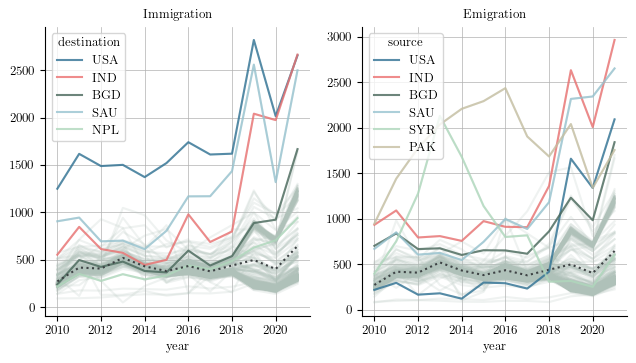

In [580]:
# Total volume of migration flow
fig, axs = plt.subplots(ncols=2, figsize=(7.5, 3.75))
_ = predicted_transport_plans.sum(['source']).plot.line(hue='destination', 
                                                    ax=axs[0], add_legend=False,
                                                    color=colors['c_lightgrey'], alpha=0.2)
_ = predicted_transport_plans.sum(['source']).sel({'destination': ["USA", "IND", "BGD", "SAU", "NPL"]}).plot.line(ax=axs[0], add_legend=True,hue='destination', alpha=0.8)
_ = predicted_transport_plans.sum(['source']).mean('destination').plot.line(ax=axs[0], color=colors['c_darkgrey'], add_legend=True, label="Mean", linestyle='dotted')
axs[0].set_title("Immigration")

_ = predicted_transport_plans.sum(['destination']).plot.line(hue='source', 
                                                    ax=axs[1], add_legend=False,
                                                    color=colors['c_lightgrey'], alpha=0.2)
_ = predicted_transport_plans.sum(['destination']).mean('source').plot.line(ax=axs[1], label="Mean", linestyle='dotted', color=colors['c_darkgrey'])
_ = predicted_transport_plans.sum(['destination']).sel({'source': ["USA", "IND", "BGD", "SAU", "SYR", "PAK"]}).plot.line(ax=axs[1], add_legend=True,hue='source', alpha=0.8)
_ =axs[1].set_title("Emigration")
fig.savefig("/Users/thomasgaskin/migration-stats_2.png", dpi=500)

In [574]:
predicted_transport_plans.coords['source'].data[predicted_transport_plans.sum(['destination']).sel({"year": 2013}).argsort()][::-1]

array(['SYR', 'PAK', 'IND', 'LBY', 'NPL', 'PHL', 'ESP', 'BGD', 'ZAF',
       'SAU', 'SSD', 'SDN', 'MMR', 'AFG', 'COL', 'VEN', 'IRN', 'KHM',
       'UGA', 'ARE', 'CAF', 'CHN', 'CIV', 'MEX', 'PER', 'SOM', 'MDA',
       'IDN', 'TZA', 'PRI', 'LKA', 'SXM', 'VIR', 'NGA', 'JEY', 'NAM',
       'REU', 'BDI', 'GUM', 'LTU', 'CYM', 'UZB', 'COK', 'TKL', 'PRY',
       'BIH', 'KEN', 'HTI', 'LAO', 'PLW', 'KNA', 'SEN', 'SPM', 'BES',
       'ABW', 'TUV', 'IMN', 'GRC', 'MAR', 'TCA', 'POL', 'PYF', 'FJI',
       'VUT', 'DOM', 'MHL', 'GIB', 'URY', 'GUF', 'TJK', 'PRK', 'XKX',
       'VNM', 'BFA', 'ZWE', 'UKR', 'TGO', 'MDG', 'CUB', 'VGB', 'TUN',
       'MAC', 'GTM', 'SLV', 'CUW', 'SHN', 'BMU', 'MLI', 'TTO', 'ARM',
       'MAF', 'KGZ', 'FLK', 'ESH', 'FRO', 'GRL', 'LVA', 'LCA', 'NIU',
       'JAM', 'SMR', 'AND', 'BLM', 'MNG', 'YEM', 'ISL', 'MNP', 'MKD',
       'CZE', 'ASM', 'DZA', 'ROU', 'DJI', 'NIC', 'MSR', 'PRT', 'MLT',
       'BWA', 'NER', 'ALB', 'KAZ', 'SYC', 'MTQ', 'TKM', 'GRD', 'TWN',
       'NRU', 'FSM',

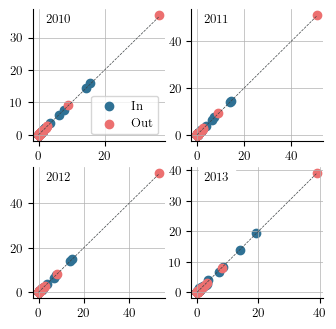

In [501]:
# Compare the predictions for NZL
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(3.75, 3.75))

cm = ColorManager(
    cmap={'from_values': {0: colors['c_lightgreen'], 0.5: colors['c_yellow'], 1: colors['c_red']}, 'continuous': True}
)
for idx, year in enumerate(YEAR_SEL):
    axs.flatten()[idx].scatter(predicted_transport_plans.sel({'destination': 'NZL', 'year': year}), 
                             known_data_table.sel({'destination': 'NZL', 'year': year}), 
                             color=colors['c_darkblue'], label='In')
    axs.flatten()[idx].scatter(predicted_transport_plans.sel({'source': 'NZL', 'year': year}), 
                             known_data_table.sel({'source': 'NZL', 'year': year}), 
                             color=colors['c_red'], label='Out')
    _max = max(
        predicted_transport_plans.sel({'destination': 'NZL', 'year': year}).max().data.item(),
        predicted_transport_plans.sel({'source': 'NZL', 'year': year}).max().data.item(),
    )
    axs.flatten()[idx].plot(
        [0, _max], [0, _max], lw=0.5, color=colors['c_darkgrey'], linestyle='dashed'
    )
    axs.flatten()[idx].text(0.1, 0.9, f"{year}", transform=axs.flatten()[idx].transAxes, backgroundcolor='white')
    if idx ==0:
        axs.flatten()[0].legend(loc='lower right')
    if idx == 3:
        break

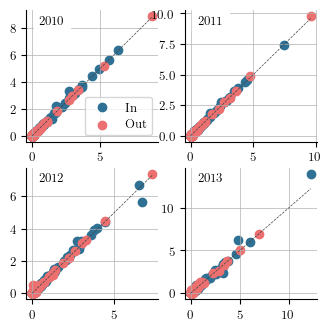

In [502]:
# Compare the predictions for SWE
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(3.75, 3.75))

cm = ColorManager(
    cmap={'from_values': {0: colors['c_lightgreen'], 0.5: colors['c_yellow'], 1: colors['c_red']}, 'continuous': True}
)
for idx, year in enumerate(YEAR_SEL):
    axs.flatten()[idx].scatter(predicted_transport_plans.sel({'destination': 'SWE', 'year': year}), 
                             known_data_table.sel({'destination': 'SWE', 'year': year}), 
                             color=colors['c_darkblue'], label='In')
    axs.flatten()[idx].scatter(predicted_transport_plans.sel({'source': 'SWE', 'year': year}), 
                             known_data_table.sel({'source': 'SWE', 'year': year}), 
                             color=colors['c_red'], label='Out')
    _max = max(
        predicted_transport_plans.sel({'destination': 'SWE', 'year': year}).max().data.item(),
        predicted_transport_plans.sel({'source': 'SWE', 'year': year}).max().data.item(),
    )
    axs.flatten()[idx].plot(
        [0, _max], [0, _max], lw=0.5, color=colors['c_darkgrey'], linestyle='dashed'
    )
    axs.flatten()[idx].text(0.1, 0.9, f"{year}", transform=axs.flatten()[idx].transAxes, backgroundcolor='white')
    if idx ==0:
        axs.flatten()[0].legend(loc='lower right')
    if idx == 3:
        break
fig.savefig("/Users/thomasgaskin/data_SWE.png", dpi=400)

In [583]:
# # Plot the predicted flow of migrants for a given year
# # World map plot
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.feature import LAND, BORDERS
import networkx as nx
import pandas as pd 
from pyproj import Transformer


# Read the country coordinates
country_coords = pd.read_csv("/Users/thomasgaskin/UN_migration_data/Coordinates.csv", index_col=2)
country_coords = country_coords[~country_coords.index.duplicated()]
nw = nx.DiGraph()

year = 2010 #YEAR_SEL[np.random.choice(len(YEAR_SEL), 1)[0]]
pred = known_data_table.sel({"year": 2019}, drop=True) # predicted_transport_plans.sel({"year": year}, drop=True) # 

# Add the exporters
for country in pred.coords['source'].data:

    nw.add_node(country, pos=(country_coords.loc[country, 'Latitude'], 
                              country_coords.loc[country, 'Longitude']),
                net_migration=UN_data['Net Number of Migrants (thousands)'].sel({"year": year, "country": country}))

# Add edges
for source in pred.coords['source'].data:
    for dest in pred.coords['destination'].data:
        if source == dest:
            continue
        T = pred.sel({"source": source, "destination": dest})
        if np.isnan(T.data.item()):
            continue
        nw.add_edge(source, dest, weight=T.data.item())

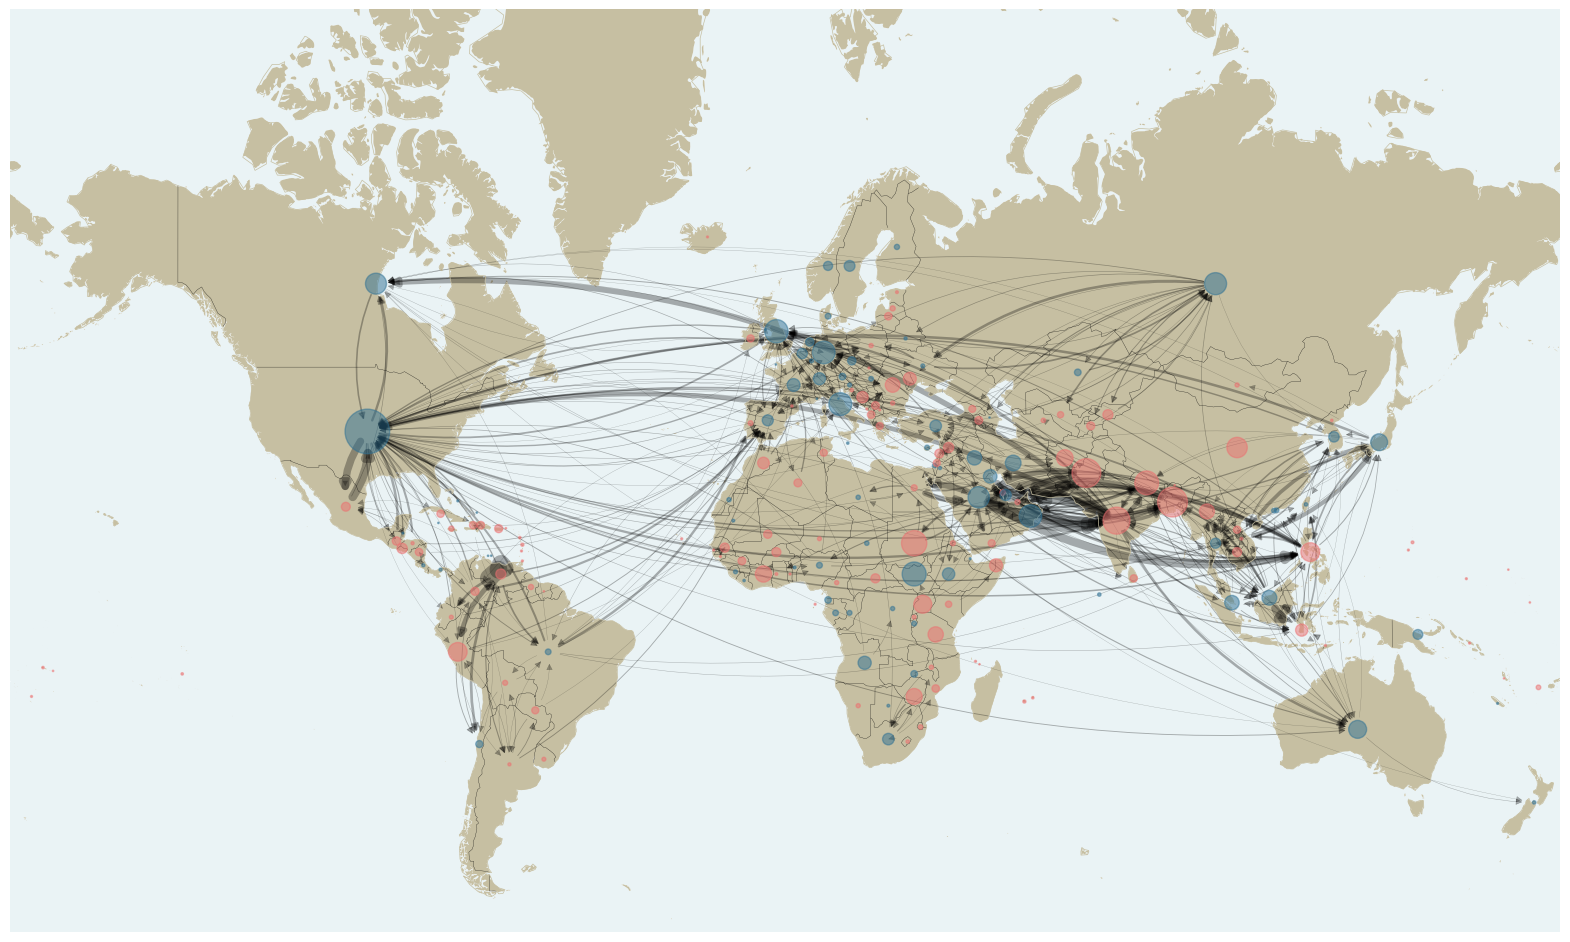

In [585]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(projection=ccrs.Mercator()))
ax.coastlines(color=colors['c_lightbrown'], lw=0.5)
land = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', facecolor=colors['c_lightbrown'])
sea = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m', facecolor=colors['c_lightblue'], alpha=0.2)
ax.axis('off')
ax.set_extent([-180, 180, -60, 80])
ax.add_feature(land, zorder=-2)
ax.add_feature(sea, zorder=-3)
ax.add_feature(BORDERS, lw=0.2, zorder=-1)
 
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

# Plot the nodes
node_pos = dict((k, transformer.transform(*v)) for k, v in nx.get_node_attributes(nw, 'pos').items())
node_size = dict((k, abs(v)) for k, v in nx.get_node_attributes(nw, 'net_migration').items())
node_colors = [colors['c_red'] if v < 1 else colors['c_darkblue'] for v in nx.get_node_attributes(nw, 'net_migration').values()]
nx.draw_networkx_nodes(nw, node_pos, ax=ax, node_size=list(node_size.values()), node_color=node_colors, alpha=0.5)

# Plot the n largest flows
n = 500
edges = dict(((u[0], u[1]), u[2]) for u in sorted([(k[0], k[1], v) for k, v in nx.get_edge_attributes(nw, 'weight').items()], key=lambda l: l[-1], reverse=True)[:n])

_ = nx.draw_networkx_edges(nw, node_pos, edges, ax=ax, alpha=0.3, 
                           width=0.02*np.array(list(edges.values())),
                           connectionstyle='arc3, rad=0.2', arrowsize=10)
# ax.text(0.01, 0.97, f"Year: {year}", transform=ax.transAxes)
fig.savefig("/Users/thomasgaskin/known_data.png", dpi=300)

In [47]:
code_to_iso3 = (pd.read_csv("/Users/thomasgaskin/UN_migration_data/Iso_code_lookup.csv")[["Numeric", "Alpha-3 code"]]).set_index("Numeric")
code_to_iso3 = code_to_iso3[~code_to_iso3.index.isna()]
code_to_iso3.index = code_to_iso3.index.astype(int)
code_to_iso3 = code_to_iso3.to_dict()['Alpha-3 code']

In [126]:
stock_data = pd.read_csv("/Users/thomasgaskin/UN_migration_data/UN_stock_data/Table 1-Table 1.csv", low_memory=False, index_col=0)
stock_data.drop(["1990.1", "1995.1", "2000.1", "2005.1", "2010.1", "2015.1", "2020.1", 
                 "1990.2", "1995.2", "2000.2", "2005.2", "2010.2", "2015.2", "2020.2", 
                 "Notes of destination", "Type of data of destination"], axis=1, inplace=True)
print(stock_data.columns, f', Length: {len(stock_data.index)}')

Index(['Region, development group, country or area of destination',
       'Location code of destination',
       'Region, development group, country or area of origin',
       'Location code of origin', '1990', '1995', '2000', '2005', '2010',
       '2015', '2020'],
      dtype='object') , Length: 37051


In [127]:
stock_data['Origin ISO'] = [code_to_iso3.get(x, None) for x in stock_data['Location code of origin']]
stock_data['Destination ISO'] = [code_to_iso3.get(x, None) for x in stock_data['Location code of destination']]

In [128]:
rows_to_drop = []
for idx, row in stock_data.iterrows():
    if row['Origin ISO'] is None or row['Destination ISO'] is None:
        rows_to_drop.append(idx)
stock_data.drop(rows_to_drop, axis=0, inplace=True)
print(f'Dropped {len(rows_to_drop)} rows')

Dropped 25100 rows


In [129]:
stock_data.rename({'Location code of origin': 'Origin Numeric', 
                   'Location code of destination': 'Destination Numeric',
                   'Region, development group, country or area of destination': 'Destination', 
                   'Region, development group, country or area of origin': 'Origin'}, axis=1, inplace=True)

In [130]:
stock_data['Origin'] = [iso3_to_name.get(x) for x in stock_data['Origin ISO']]
stock_data['Destination'] = [iso3_to_name.get(x) for x in stock_data['Destination ISO']]

In [131]:
# stock_data = stock_data.set_index(['Origin', 'Destination'])

In [132]:
def replace(_s):
    if _s == "0..":
        return np.nan 
    else:
        return(int(_s.replace(' ', '')))
for col in ["1990", "1995", "2000", "2005", "2010", "2015", "2020"]:
    stock_data[col] = [replace(s) for s in stock_data[col]]

In [136]:
l = []
for year in ["1990", "1995", "2000", "2005", "2010", "2015", "2020"]:
    data_year = stock_data[["Origin ISO", "Destination ISO", year]].copy()
    data_year["Year"] = int(year)
    data_year.rename({year: "Stock"}, axis=1, inplace=True)
    l.append(data_year)

In [155]:
ds = pd.concat(l, axis=0).set_index(["Origin ISO", "Destination ISO", "Year"]).to_xarray()['Stock']

In [156]:
diffs = ds.diff('Year', label='upper')

In [181]:
print(ds.sel({"Origin ISO": "IND", "Destination ISO": "USA"}).data,
ds.sel({"Origin ISO": "SYR", "Destination ISO": "DEU"}))

[ 450406.  746337. 1048517. 1390605. 1784284. 2389639. 2723764.] <xarray.DataArray 'Stock' (Year: 7)>
array([ 15330.,  20223.,  25116.,  34895.,  42766., 197186., 707457.])
Coordinates:
    Origin ISO       <U3 'SYR'
    Destination ISO  <U3 'DEU'
  * Year             (Year) int64 1990 1995 2000 2005 2010 2015 2020


In [163]:
diffs.coords['Origin ISO']

<xarray.DataArray 'Origin ISO' (Origin ISO: 231)>
array(['ABW', 'AFG', 'AGO', ..., 'ZAF', 'ZMB', 'ZWE'], dtype=object)
Coordinates:
  * Origin ISO  (Origin ISO) object 'ABW' 'AFG' 'AGO' ... 'ZAF' 'ZMB' 'ZWE'